# Iterative train example

This notebook demonstrates how to use `dpmd-tools` iterative datsaset building. The steps are:

1. read data from some of the supported formats to deepmd format
2. compute Oganov fingerprints
3. cluser data based on computed fingerprints
4. select first data randomly with help of fingerprints
5. train new NN models
6. compute Energy/Forces predictions for all data with new models
7. based on these predictions select new data to add to dataset

Note: "!" lets you use bash commands in ipython shell

## 1. Read data from some of the supported formats to deepmd format

First we need to load the data, for that we will use `to_deepmd` subpackage.

In [47]:
!dpmd-tools -h
!dpmd-tools to_deepmd -h

usage: dpmd-tools [-h]
                  {to_deepmd,ev,take-prints,assign-clusters,upload,recompute,rings}
                  ...

dpmd-tools an enhanced data manager for deepmd

optional arguments:
  -h, --help            show this help message and exit

Valid subcommands:
  {to_deepmd,ev,take-prints,assign-clusters,upload,recompute,rings}
    to_deepmd           Load various data formats to deepmd. Loaded data will
                        be output to deepmd_data/all - (every read structure)
                        and deepmd_data/for_train - (only selected structures)
                        dirs
    ev                  run E-V plots check
    take-prints         compute oganov fingerprints for all structures in
                        dataset
    assign-clusters     assign cluster number to each structure
    upload              upload dataset to remote and local dir
    recompute           script to recompute arbitrarry atoms set
    rings               script to recompute arbitrar

The selection criteria for volume the interval (0, 0) are set this way so no structures are selected. We essentially only want to convert data to "our" format. We do not have the clusters data yet so in principle we can do selection but it would have to be completely random. With clusters we can make a better selection. You can select from more different files at once the only contition is that all read structures have the same number of atoms.

In [9]:
!cd data && dpmd-tools to_deepmd --parser vasp_file --volume 0 0 --per-atom --get-paths '[Path.cwd() / "OUTCAR"]' --mode new --auto-save --data-collector cf

m - std_method          : False
 - mode                : new
 - fingerprint_use     : False
 - max_select          : None
 - min_frames          : 30
 - n_from_cluster      : 100
 - cache_predictions   : False
 - auto_save           : True
 - dont_save           : False
 - block_pbs           : False
 - data_collector      : cf
 - force_iteration     : None
 - profile             : False
 - wait_for            : None
will read from these paths:
 - /mnt/md0/OneDrive/dizertacka/code/dpmd_tools/examples/data/OUTCAR
/mnt/md0/OneDrive/dizertacka/code/dpmd_tools/dpmd_tools/to_deepmd/to_deepmd.py:265: UserWarning:

It is strongly advised to use filtering based on currently trained model

All atom types will be changed to Ge!!!
extracting: OUTCAR: 100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.93it/s]
got these systems -------------------------------------------
 - Ge256  ->   50 structures
filtering data ----------------------------------------------
Number of frames

## 2. Now move to directory where all read data is located and compute fingerprints.

In [12]:
import os
os.chdir("data/deepmd_data/all/Ge256")
!pwd
!ls -l

/mnt/md0/OneDrive/dizertacka/code/dpmd_tools/examples/data/deepmd_data/all/Ge256
.rw-r--r--  11k rynik 29 Mar 17:08 box.raw
.rw-r--r-- 960k rynik 29 Mar 17:08 coord.raw
.rw-r--r-- 1.3k rynik 29 Mar 17:08 energy.raw
.rw-r--r-- 979k rynik 29 Mar 17:08 force.raw
.rw-r--r--  512 rynik 29 Mar 17:08 type.raw
.rw-r--r--    3 rynik 29 Mar 17:08 type_map.raw
.rw-r--r--  100 rynik 29 Mar 17:08 used.raw
.rw-r--r--  11k rynik 29 Mar 17:08 virial.raw


This will ouput numpy binary format file(s) with fingerprints (batch size determines how much files will be output, if all structures can fit to RAM set it higher than processed dataset size and you will only have one file). The fingerprint compute settings are stored in yaml file and are optimal for Ge system, so for other system you have to come up with your own settings. This one works for systems with one atom type.

In [25]:
!dpmd-tools take-prints --batch-size 10000 -p --settings-file ../../../../OFP_settings.yaml

Script was run with these arguments --------------------------
 - command             : take-prints
 - batch_size          : 10000
 - parallel            : True
 - settings_file       : ../../../../OFP_settings.yaml
fingeprinting: Ge256
 - loading from raw
Will now take fingerprints for dataset
 - processing chunk 1/1
100%|███████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 17.71it/s]
 - dumping fingerprints_1.npy


## 3. Devide data to clusters.

This uses K-Means Minibatch clustering algorith from sickit-learn to keep memory requirements low. You can cluster virtually infinite datasets this way even with small amount of RAM. NUmber of whole dataset passe has to be rather high for this to converge properly. Do not make clusters too small. Good cluster size strongly depends on data diversity, but for example 1000 structure per cluster is OK. Parameters here are not representstive since we have only 50 structures. Afterwards you can check the convergence `convergence.html` and coverage output graphs in either png or html format.

In [38]:
!dpmd-tools assign-clusters --passes 1 --n-clusters 5


Script was run with these arguments --------------------------
 - command             : assign-clusters
 - passes              : 1
 - batch_size          : 1000000
 - n_clusters          : 5
Found fingerprint files ----------------------------------
 - fingerprints_1.npy
Training cluster representation from file: fingerprints_1.npy
inertia: 0.008875: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.11s/it]
Computing label assignment and total inertia


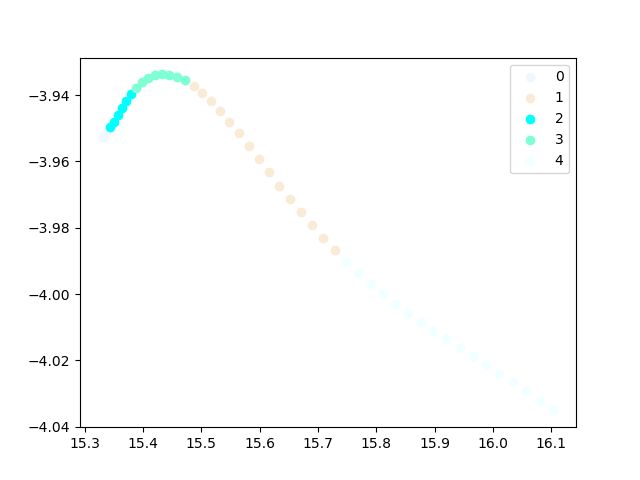

In [46]:
from IPython.display import Image
Image(filename='clusters.png')
#from IPython.display import IFrame
#IFrame(src='./convergence.html', width=1000, height=1000)

Now we can check the fingerprint data. It is saved in `clusters.raw` file.

In [49]:
!ls -l
import numpy as np
np.loadtxt("clusters.raw")

.rw-r--r--  11k rynik 29 Mar 17:08 box.raw
.rw-r--r--  10k rynik 29 Mar 17:46 clusters.html
.rw-r--r--  16k rynik 29 Mar 17:46 clusters.png
.rw-r--r--  200 rynik 29 Mar 17:46 clusters.raw
.rw-r--r-- 8.8k rynik 29 Mar 17:46 convergence.html
.rw-r--r-- 960k rynik 29 Mar 17:08 coord.raw
.rw-r--r-- 1.3k rynik 29 Mar 17:08 energy.raw
.rw-r--r--  173 rynik 29 Mar 17:28 fingerprint_settings.json
.rw-r--r--  50k rynik 29 Mar 17:28 fingerprints_1.npy
.rw-r--r-- 979k rynik 29 Mar 17:08 force.raw
.rw-r--r--  512 rynik 29 Mar 17:08 type.raw
.rw-r--r--    3 rynik 29 Mar 17:08 type_map.raw
.rw-r--r--  100 rynik 29 Mar 17:08 used.raw
.rw-r--r--  11k rynik 29 Mar 17:08 virial.raw


array([0., 0., 0., 0., 2., 2., 2., 2., 2., 2., 3., 3., 3., 3., 3., 3., 3.,
       3., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 4.,
       4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.])

## 4. Now that we have fingerprints we finally can make first training set selection.

First go back to deepmd_data directory. We will select 10% of structures (=5 structures) in this toy example. 

In [50]:
!pwd
os.chdir("../..")
!pwd

/mnt/md0/OneDrive/dizertacka/code/dpmd_tools/examples/data/deepmd_data/all/Ge256
/mnt/md0/OneDrive/dizertacka/code/dpmd_tools/examples/data/deepmd_data


In [55]:
!dpmd-tools to_deepmd --parser dpmd_raw --volume 10 30 --energy -5 -2 --per-atom --mode append --data-collector cf --fingerprint-use --max-select 10% --min-frames 0 --save yes


Appending logs: 29/03/2021 20:49:15

Script was run with these arguments -------------------------
 - command             : to_deepmd
 - parser              : dpmd_raw
 - graphs              : []
 - every               : None
 - volume              : [10.0, 30.0]
 - energy              : [-5.0, -2.0]
 - per_atom            : True
 - get_paths           : None
 - dev_energy          : False
 - dev_force           : False
 - std_method          : False
 - mode                : append
 - fingerprint_use     : True
 - max_select          : 10%
 - min_frames          : 0
 - n_from_cluster      : 100
 - cache_predictions   : False
 - save                : yes
 - block_pbs           : False
 - data_collector      : cf
 - force_iteration     : None
 - profile             : False
 - wait_for            : None
will read from these paths:
 - /mnt/md0/OneDrive/dizertacka/code/dpmd_tools/examples/data/deepmd_data/all/Ge256
/mnt/md0/OneDrive/dizertacka/code/dpmd_tools/dpmd_tools/to_deepmd/to_deepmd

We can look at the saved data now. It has added `iteration.raw` file that records which structures were added in which generation. But otherwise there is nothing interesting.

In [56]:
!ls -l for_train/Ge256/

.rw-r--r--  10 rynik 29 Mar 20:49 iteration.raw
drwxr-xr-x   - rynik 29 Mar 20:49 set.000
drwxr-xr-x   - rynik 29 Mar 20:49 set.001
drwxr-xr-x   - rynik 29 Mar 20:49 set.002
drwxr-xr-x   - rynik 29 Mar 20:49 set.003
drwxr-xr-x   - rynik 29 Mar 20:49 set.004
.rw-r--r-- 512 rynik 29 Mar 20:49 type.raw
.rw-r--r--   3 rynik 29 Mar 20:49 type_map.raw


## 5. Train first DeepMD models

Now train at least two models (whuích is the bare minimum, dpgen uses 4) based on selected data so we can start with new selection iteration. You can use the `dpmd-tools upload` subpackage to handle data organization for you. But if you want to use it you have to have ssh keys configured.

In [57]:
!pwd
os.chdir("../..")
!pwd

/mnt/md0/OneDrive/dizertacka/code/dpmd_tools/examples/data/deepmd_data
/mnt/md0/OneDrive/dizertacka/code/dpmd_tools/examples


In [58]:
!dpmd-tools upload -h -s kohn -t /path/to/remote/train/data/dir -l /path/to/local/data/dir -d data

usage: dpmd-tools upload [-h] -s
                         {kohn,aurel,planck,fock,hydra,schrodinger,landau,hartree,dusanko,bardeen}
                         [-t TARGET] [-l LOCAL] -d DIRS [DIRS ...]

optional arguments:
  -h, --help            show this help message and exit
  -s {kohn,aurel,planck,fock,hydra,schrodinger,landau,hartree,dusanko,bardeen}, --server {kohn,aurel,planck,fock,hydra,schrodinger,landau,hartree,dusanko,bardeen}
                        select target server to upload to (default: None)
  -t TARGET, --target TARGET
                        select target directory to upload to, if not
                        specified, script will mirror local directory
                        (default: None)
  -l LOCAL, --local LOCAL
                        select LOCAL target directory to mirror data uploaded
                        to remote (default: None)
  -d DIRS [DIRS ...], --dirs DIRS [DIRS ...]
                        select data directories. It is assumed that these were
 

We will use our pretrained models to demonstrate further progress. Keep in mind that the model compatibility is only between minor `deepmd-kit` versions, so for this example to run you will need `deepmd-kit==1.3.x`

## 6. & 7. compute trained models predictions for dataset and decide which structures are not known to current models.

Go again to `deepmd_data` dir and you can run new selection, now with forces prediction based filtering.

In [60]:
os.chdir("data/deepmd_data")
!pwd

/mnt/md0/OneDrive/dizertacka/code/dpmd_tools/examples/data/deepmd_data


Notice the added graphs argument, it accepts all shell glob expresions or you can input graph paths one by one. It can even copy graphs from remote server if you have ssh keys configured. It is probably betted to use `--std-method` for predictions. You can use `--cache-predictions` in tandem with `--save no/input` to make a "dry run" and look at the results before commiting to change the training dataset. Computing prediction is best done on GPU because for larger datasets it can be very slow on CPU. You will hopefully see after running this cell that out of the 45 previously unselected structures 37 do not meet the force deviation criteria.

In [61]:
!dpmd-tools to_deepmd --parser dpmd_raw --volume 10 30 --energy -5 -2 --per-atom --mode append --data-collector cf --fingerprint-use --max-select 10% --min-frames 0 --save yes --graphs ../../models/ge_all_s1_[1-2].pb --dev-force 0.1 0.5 --cache-predictions --std-method

Getting graph from local: ../../models/ge_all_s1_1.pb
Getting graph from local: ../../models/ge_all_s1_2.pb

Appending logs: 29/03/2021 21:19:31

Script was run with these arguments -------------------------
 - command             : to_deepmd
 - parser              : dpmd_raw
 - graphs              : [PosixPath('/mnt/md0/OneDrive/dizertacka/code/dpmd_tools/examples/data/deepmd_data/ge_all_s1_1.pb'), PosixPath('/mnt/md0/OneDrive/dizertacka/code/dpmd_tools/examples/data/deepmd_data/ge_all_s1_2.pb')]
 - every               : None
 - volume              : [10.0, 30.0]
 - energy              : [-5.0, -2.0]
 - per_atom            : True
 - get_paths           : None
 - dev_energy          : False
 - dev_force           : [0.1, 0.5]
 - std_method          : True
 - mode                : append
 - fingerprint_use     : True
 - max_select          : 10%
 - min_frames          : 0
 - n_from_cluster      : 100
 - cache_predictions   : True
 - save                : yes
 - block_pbs           : Fal

There is one more important swith: `--force-iteration` this lets you roll back changes and "forget" structures you have selected in previous iterations. Because every saved iteration is persisted to disk in `used.raw` file once you chose to save training data. So if you for instance would after saving this selection find taht trining results are unsatisfactory and you want to discard it. You cant run the script with `--force-iteration -1`. This will set the selection back one iteration as if the last selection dir not happen.

To view results of your last selection - README file records all **saved** selections. You will see both selection runs we have done recorded there.

In [62]:
!cat README

Script was run with these arguments -------------------------
 - command             : to_deepmd
 - parser              : vasp_file
 - graphs              : []
 - every               : None
 - volume              : [0.0, 0.0]
 - energy              : None
 - per_atom            : True
 - get_paths           : [Path.cwd() / "OUTCAR"]
 - dev_energy          : False
 - dev_force           : False
 - std_method          : False
 - mode                : new
 - fingerprint_use     : False
 - max_select          : None
 - min_frames          : 30
 - n_from_cluster      : 100
 - cache_predictions   : False
 - auto_save           : True
 - dont_save           : False
 - block_pbs           : False
 - data_collector      : cf
 - force_iteration     : None
 - profile             : False
 - wait_for            : None
will read from these paths:
 - /mnt/md0/OneDrive/dizertacka/code/dpmd_tools/examples/data/OUTCAR
got these systems -------------------------------------------
 - Ge256  ->   50 struct

There are also `html` graphs which show current prediction erros. The are labeled by iteration. These can help you decide if your selction criteria yielded expecteed result. 